In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ruptures as rpt
import pymc as pm
import arviz as az 
import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv('../Data/BrentOilPrices.csv')
df.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [6]:
df.shape

(9011, 2)

In [13]:
df.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


In [15]:
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=False)
df = df.sort_values(by='Date')
df = df.set_index('Date')
df['Price'] = df['Price'].interpolate(method='time')
df = df.dropna(subset=['Price'])

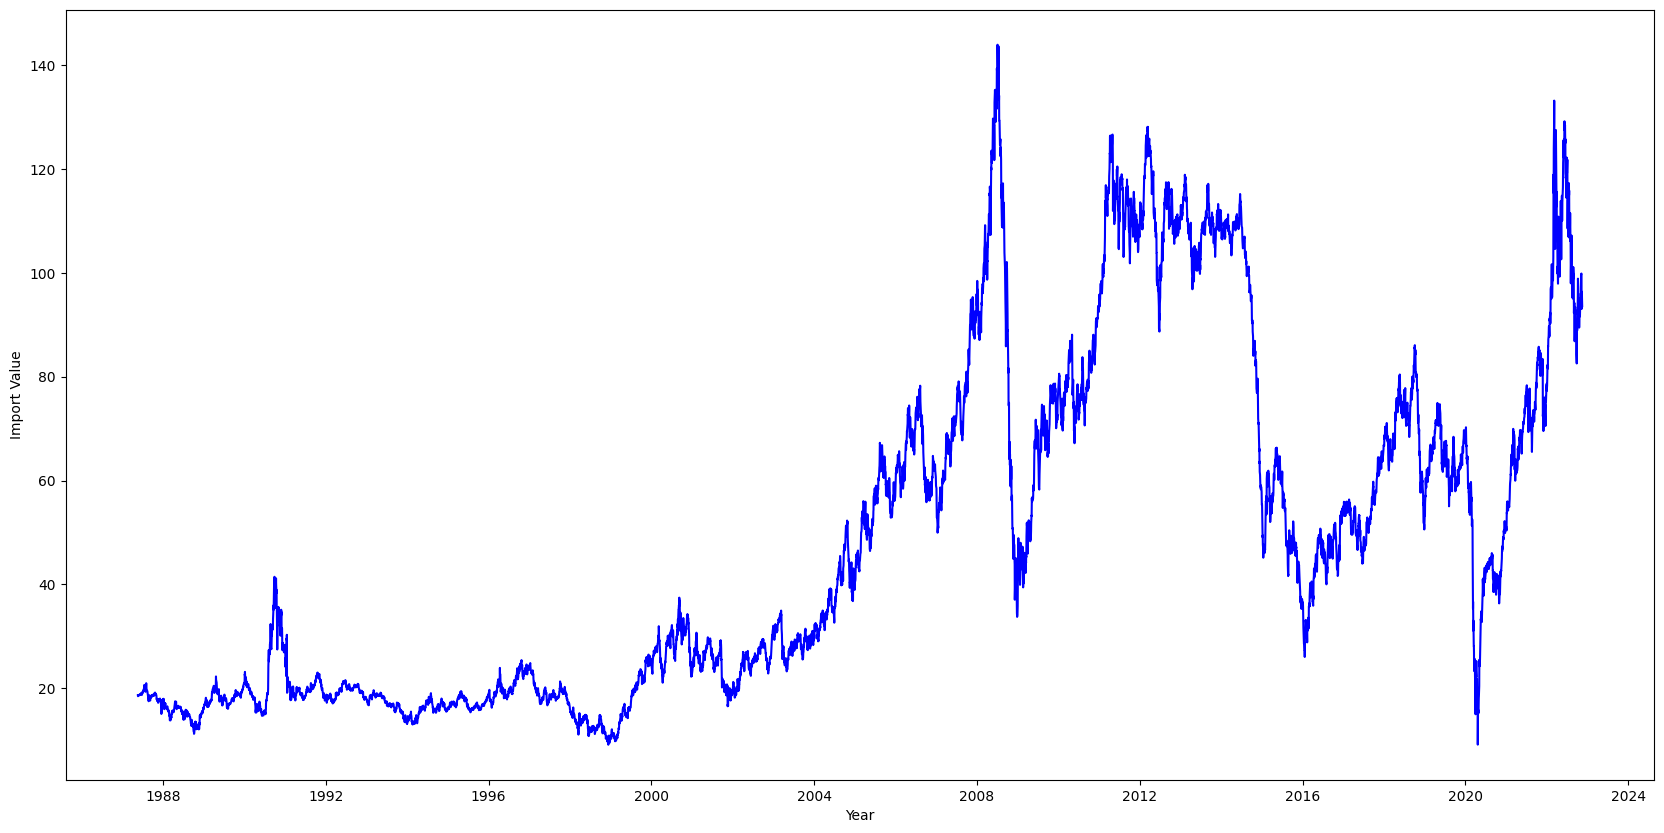

In [16]:
plt.figure(figsize=(20.5, 10))
plt.plot(df.index, df['Price'], color='blue')
plt.title('')
plt.xlabel('Year')
plt.ylabel('Import Value')
plt.grid(False)
plt.show()


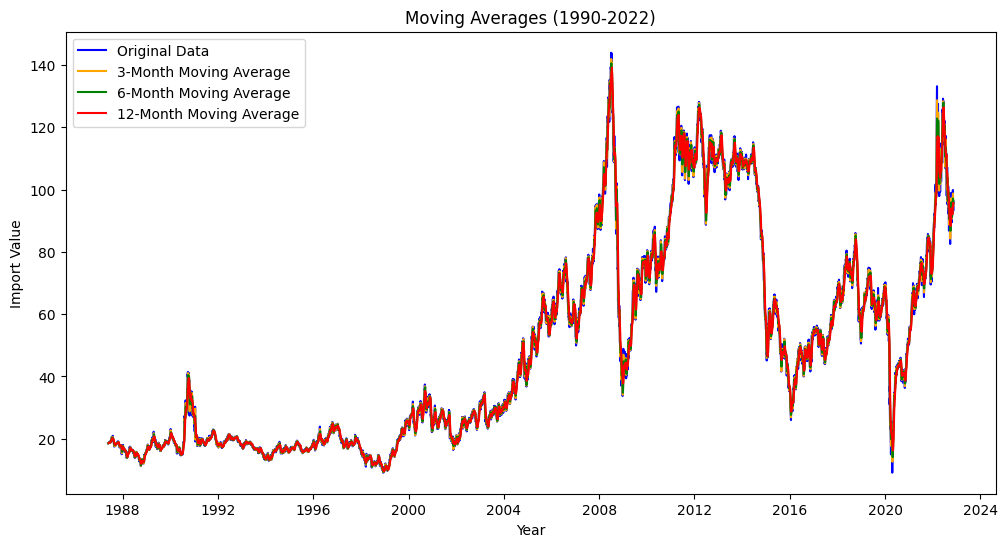

In [18]:
# Calculate the Simple Moving Average (SMA) with different window sizes
df['SMA_3'] = df['Price'].rolling(window=3).mean()  # 3-month moving average
df['SMA_6'] = df['Price'].rolling(window=6).mean()  # 6-month moving average
df['SMA_12'] = df['Price'].rolling(window=12).mean()  # 12-month moving average

# Plot the original data and the moving averages
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Original Data', color='blue')
plt.plot(df.index, df['SMA_3'], label='3-Month Moving Average', color='orange')
plt.plot(df.index, df['SMA_6'], label='6-Month Moving Average', color='green')
plt.plot(df.index, df['SMA_12'], label='12-Month Moving Average', color='red')

# Add titles and labels
plt.title('Moving Averages (1990-2022)')
plt.xlabel('Year')
plt.ylabel('Import Value')
plt.legend()
plt.grid(False)
plt.show()



In [19]:
df['Log_Return'] = np.log(df['Price']).diff().dropna()

    # The time series for analysis will be the 'Price' for ruptures and 'Log_Return' for PyMC
time_series_price = df['Price']
time_series_log_return = df['Log_Return'].dropna() # Ensure log returns are also dropped if NaN

print("Brent Oil Prices Time Series Head:")
display(time_series_price.head())
print("\nBrent Oil Prices Time Series Tail:")
display(time_series_price.tail())
print("\nBrent Oil Log Returns Time Series Head:")
display(time_series_log_return.head())
print("\nBrent Oil Log Returns Time Series Tail:")
display(time_series_log_return.tail())

Brent Oil Prices Time Series Head:


Date
1987-05-20    18.63
1987-05-21    18.45
1987-05-22    18.55
1987-05-25    18.60
1987-05-26    18.63
Name: Price, dtype: float64


Brent Oil Prices Time Series Tail:


Date
2022-11-08    96.85
2022-11-09    93.05
2022-11-10    94.25
2022-11-11    96.37
2022-11-14    93.59
Name: Price, dtype: float64


Brent Oil Log Returns Time Series Head:


Date
1987-05-21   -0.009709
1987-05-22    0.005405
1987-05-25    0.002692
1987-05-26    0.001612
1987-05-27   -0.001612
Name: Log_Return, dtype: float64


Brent Oil Log Returns Time Series Tail:


Date
2022-11-08   -0.030706
2022-11-09   -0.040026
2022-11-10    0.012814
2022-11-11    0.022244
2022-11-14   -0.029271
Name: Log_Return, dtype: float64


Detected Change Point Indices (ruptures on Price): [65, 145, 190, 225, 270, 330, 390, 415, 465, 510, 605, 660, 705, 735, 805, 820, 840, 850, 855, 870, 875, 880, 890, 905, 925, 935, 955, 1060, 1115, 1155, 1265, 1395, 1550, 1665, 1760, 1805, 1845, 2000, 2060, 2175, 2250, 2270, 2350, 2370, 2475, 2505, 2630, 2675, 2695, 2725, 2805, 2875, 2895, 2920, 3000, 3020, 3075, 3120, 3165, 3210, 3240, 3255, 3285, 3290, 3335, 3355, 3365, 3385, 3420, 3435, 3445, 3460, 3475, 3485, 3535, 3580, 3620, 3640, 3670, 3750, 3765, 3810, 3830, 3870, 3915, 3955, 3990, 4015, 4020, 4030, 4060, 4115, 4140, 4160, 4210, 4260, 4310, 4335, 4355, 4370, 4410, 4420, 4440, 4445, 4465, 4470, 4485, 4520, 4525, 4550, 4575, 4590, 4600, 4630, 4640, 4660, 4680, 4705, 4725, 4740, 4750, 4765, 4790, 4800, 4810, 4815, 4825, 4835, 4865, 4885, 4900, 4910, 4915, 4925, 4975, 4995, 5000, 5010, 5030, 5055, 5090, 5120, 5145, 5165, 5190, 5200, 5205, 5225, 5240, 5255, 5275, 5285, 5290, 5300, 5310, 5315, 5320, 5330, 5335, 5345, 5355, 5370, 538

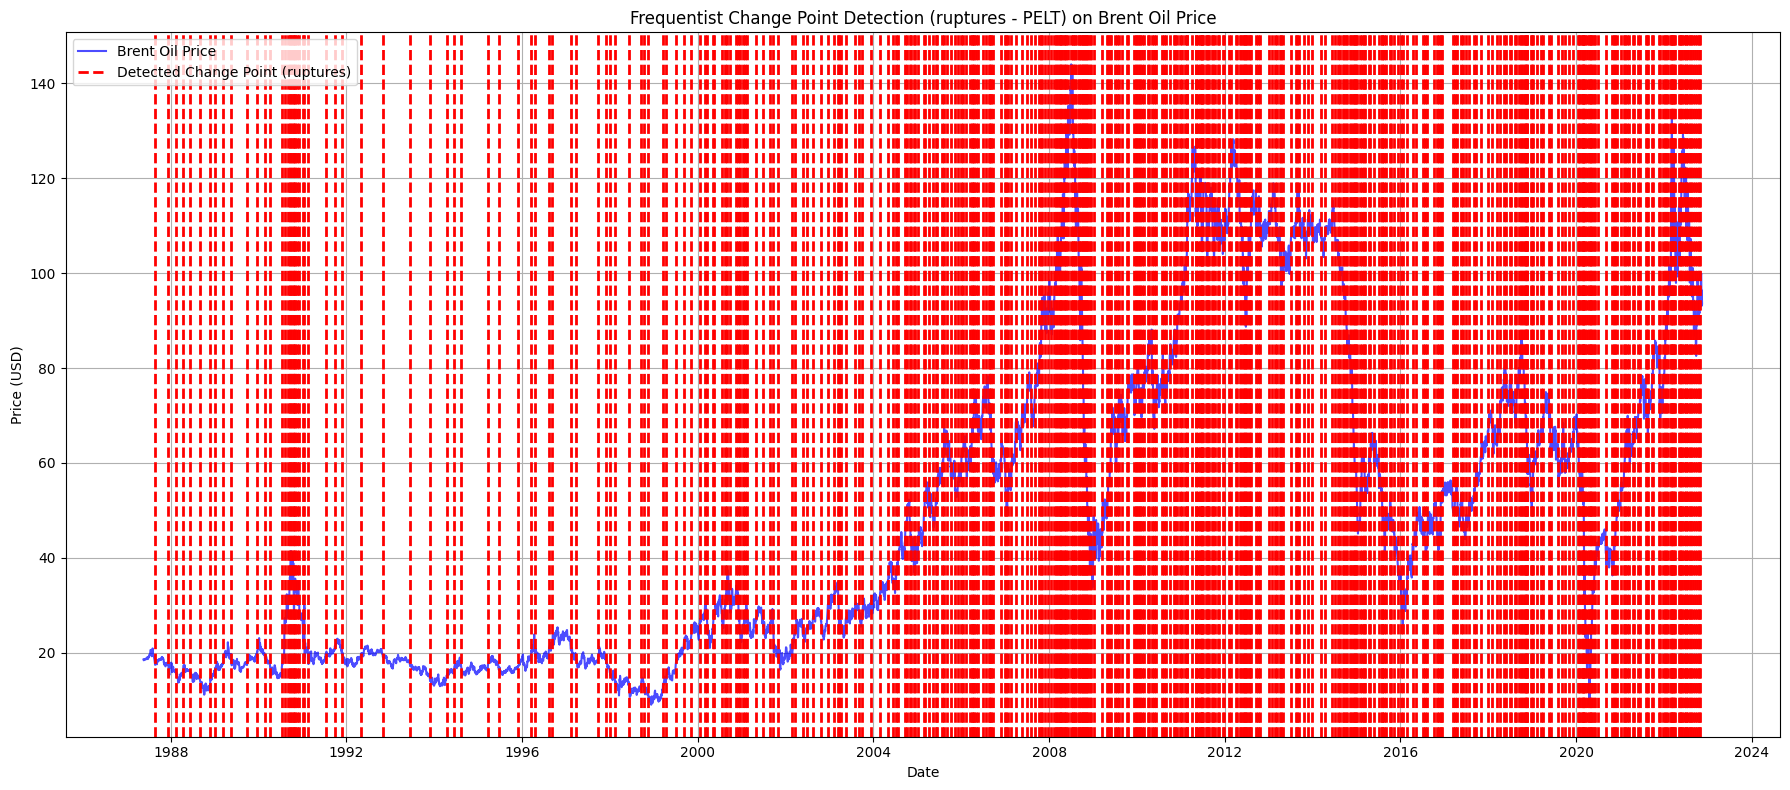

In [23]:
if 'time_series_price' in locals() and not time_series_price.empty: # Check if time_series_price was successfully created and is not empty
    signal_array_ruptures = time_series_price.values.reshape(-1, 1) 
    model_ruptures = "l2"
    algo_ruptures = rpt.Pelt(model=model_ruptures).fit(signal_array_ruptures)

    penalty_value_ruptures = 3 * np.log(len(time_series_price))
    change_points_ruptures = algo_ruptures.predict(pen=penalty_value_ruptures)
    if change_points_ruptures and change_points_ruptures[-1] == len(time_series_price):
        detected_change_point_indices_ruptures = change_points_ruptures[:-1]
    else:
        detected_change_point_indices_ruptures = change_points_ruptures

    print(f"\nDetected Change Point Indices (ruptures on Price): {detected_change_point_indices_ruptures}")

    # Convert indices to dates for plotting
    detected_change_point_dates_ruptures = time_series_price.index[detected_change_point_indices_ruptures]
    print(f"Detected Change Point Dates (ruptures on Price): {detected_change_point_dates_ruptures.tolist()}")

    # Visualization for ruptures
    plt.figure(figsize=(18, 8))
    plt.plot(time_series_price.index, time_series_price.values, label='Brent Oil Price', color='blue', alpha=0.7)
    # Plot change points with labels, ensuring only one label is created for the legend
    for i, cp_date in enumerate(detected_change_point_dates_ruptures):
        plt.axvline(x=cp_date, color='red', linestyle='--', linewidth=2, label='Detected Change Point (ruptures)' if i == 0 else "")
    plt.title('Frequentist Change Point Detection (ruptures - PELT) on Brent Oil Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Frequentist Change Point Detection as price time series data is not available or empty.")


Starting PyMC sampling for Bayesian Volatility Change Point Detection...


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [sigma_1, sigma_2, mu_log_return]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


PyMC Sampling Complete.

Bayesian Volatility Model Sampling Complete. Summary of parameters:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,5390.172,21.067,5344.000,5419.000,0.894,0.631,597.0,770.0,1.01
mu_log_return,0.000,0.000,-0.000,0.001,0.000,0.000,5383.0,2887.0,1.00
sigma_1,0.023,0.000,0.023,0.023,0.000,0.000,5986.0,3304.0,1.00
sigma_2,0.029,0.000,0.028,0.029,0.000,0.000,4660.0,3130.0,1.00



Most Probable Change Point Index (PyMC on Log Returns): 5406
Most Probable Change Point Date (PyMC on Log Returns): 2008-08-21 00:00:00


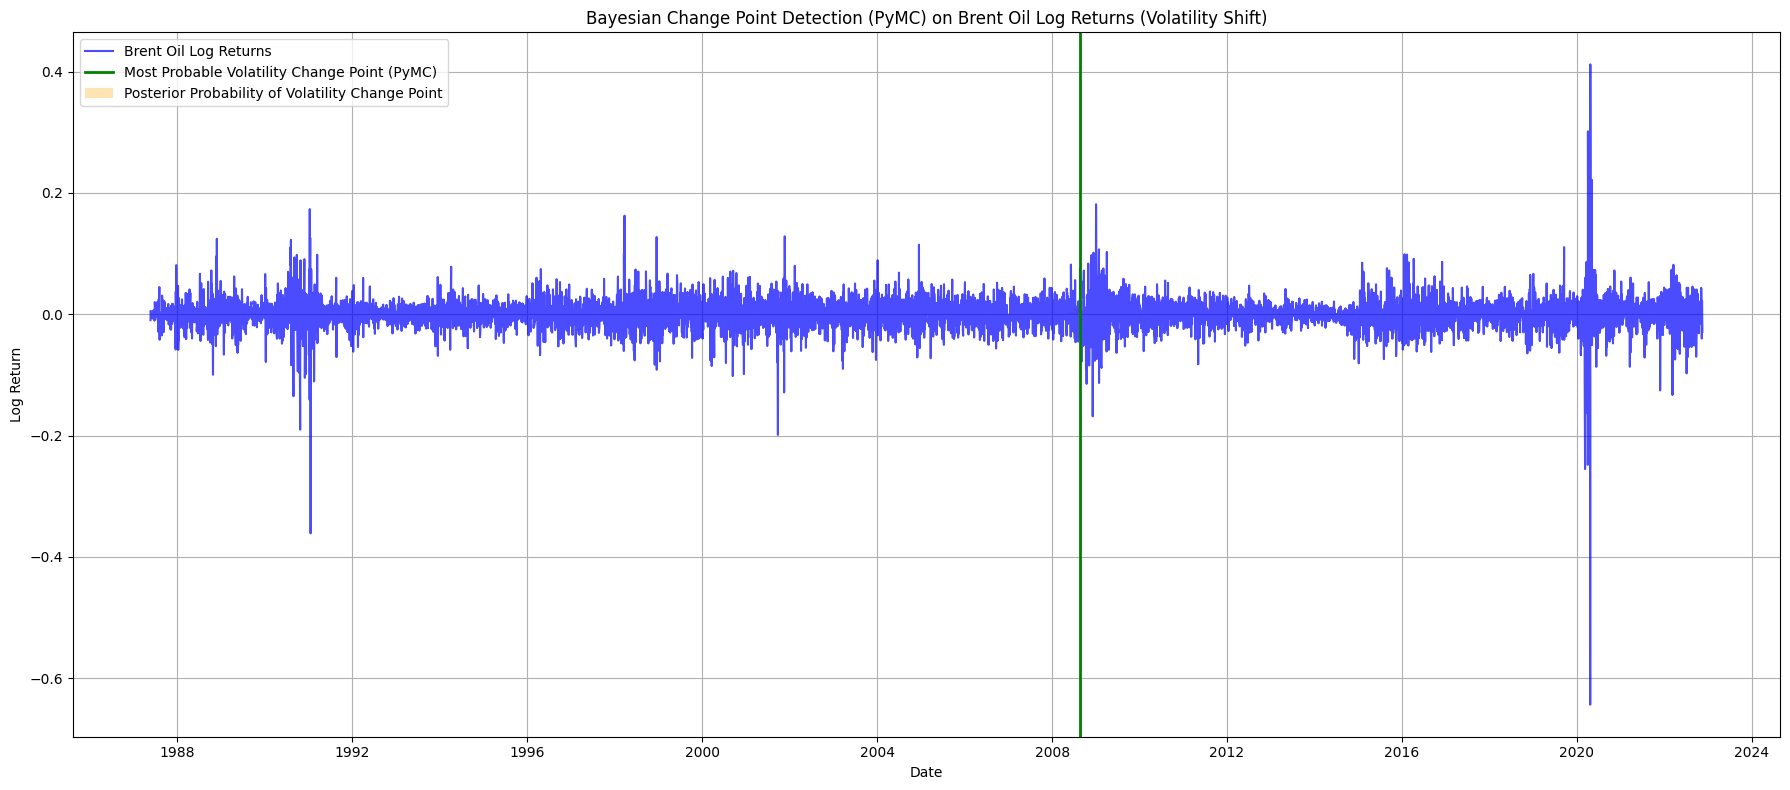

In [27]:
if 'time_series_log_return' in locals() and not time_series_log_return.empty: # Check if log returns were successfully created and are not empty
    # Convert log returns to numpy array for PyMC
    data_pymc_log_return = time_series_log_return.values

    # Define the Bayesian model
    with pm.Model() as bayesian_volatility_change_point_model:
        tau = pm.DiscreteUniform("tau", lower=0, upper=len(data_pymc_log_return) - 1)
        sigma_1 = pm.HalfNormal("sigma_1", sigma=0.1) 
        sigma_2 = pm.HalfNormal("sigma_2", sigma=0.1) 
        mu_log_return = pm.Normal("mu_log_return", mu=0, sigma=0.01)

        # Define the standard deviation for each data point based on the change point location (tau)
        idx = np.arange(len(data_pymc_log_return))
        sigma = pm.math.switch(idx < tau, sigma_1, sigma_2)

        observation = pm.Normal("observation", mu=mu_log_return, sigma=sigma, observed=data_pymc_log_return)
        print("\nStarting PyMC sampling for Bayesian Volatility Change Point Detection...")
        trace_volatility = pm.sample(draws=2000, tune=1000, chains=2, random_seed=42, return_inferencedata=True, cores=1)
        print("PyMC Sampling Complete.")

    print("\nBayesian Volatility Model Sampling Complete. Summary of parameters:")
    display(az.summary(trace_volatility, var_names=["tau", "mu_log_return", "sigma_1", "sigma_2"]))

    # Analyze the posterior distribution of the change point (tau)
    tau_samples_volatility = trace_volatility.posterior["tau"].values.flatten()
    most_probable_tau_index_volatility = int(pd.Series(tau_samples_volatility).mode())
    # The log_return series starts one day after the price series, so adjust index for original date mapping
    most_probable_tau_date_volatility = time_series_log_return.index[most_probable_tau_index_volatility]

    print(f"\nMost Probable Change Point Index (PyMC on Log Returns): {most_probable_tau_index_volatility}")
    print(f"Most Probable Change Point Date (PyMC on Log Returns): {most_probable_tau_date_volatility}")

    plt.figure(figsize=(18, 8))
    plt.plot(time_series_log_return.index, time_series_log_return.values, label='Brent Oil Log Returns', color='blue', alpha=0.7)
    # Plot the most probable change point
    plt.axvline(x=most_probable_tau_date_volatility, color='green', linestyle='-', linewidth=2, label='Most Probable Volatility Change Point (PyMC)')
    plt.hist(time_series_log_return.index[tau_samples_volatility], bins=50, density=True, alpha=0.3, color='orange', label='Posterior Probability of Volatility Change Point')

    plt.title('Bayesian Change Point Detection (PyMC) on Brent Oil Log Returns (Volatility Shift)')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Bayesian Change Point Detection as log return data is not available or empty.")

In [28]:
print("\n--- Conceptual Further Analysis ---")
print("For both frequentist and Bayesian approaches, the next steps would typically involve:")
print("a. Contextualizing: What real-world events or policy changes occurred around these dates?")
print("   - For example, if analyzing Brent oil prices, a change point might correspond to a major OPEC decision, a geopolitical conflict, or a global economic sanction.")
print("b. Quantifying Impact: Analyze the statistical properties (mean, variance, trend) of the segments")
print("   before and after each change point to understand the magnitude and nature of the shift.")

# Example of quantifying impact for ruptures (Price Mean Shift)
if 'detected_change_point_indices_ruptures' in locals() and len(detected_change_point_indices_ruptures) > 0 and 'time_series_price' in locals():
    print("\n--- Ruptures (Price Mean Shift) Impact ---")
    segments = [0] + detected_change_point_indices_ruptures + [len(time_series_price)]
    for i in range(len(segments) - 1):
        start_idx = segments[i]
        end_idx = segments[i+1]
        segment_data = time_series_price.iloc[start_idx:end_idx]
        if not segment_data.empty:
            # Ensure end_idx is within bounds when accessing index
            end_date_idx = end_idx - 1 if end_idx > 0 else 0
            print(f"Segment {i+1} (Price): {time_series_price.index[start_idx].strftime('%Y-%m-%d')} to {time_series_price.index[end_date_idx].strftime('%Y-%m-%d')}")
            print(f"  Mean Price: {segment_data.mean():.2f} USD")
            print(f"  Std Dev Price: {segment_data.std():.2f} USD")
            if i > 0:
                prev_segment_data = time_series_price.iloc[segments[i-1]:segments[i]]
                if not prev_segment_data.empty:
                    prev_segment_mean = prev_segment_data.mean()
                    if not pd.isna(prev_segment_mean):
                        price_change = segment_data.mean() - prev_segment_mean
                        percent_change = (price_change / prev_segment_mean) * 100 if prev_segment_mean != 0 else float('inf') # Handle division by zero
                        print(f"  Change from previous segment: {price_change:.2f} USD ({percent_change:.2f}%)")
else:
    print("\n--- Ruptures (Price Mean Shift) Impact ---")
    print("Skipping impact analysis for ruptures as change points were not detected or data is not available.")

# Example of quantifying impact for PyMC (Log Return Volatility Shift)
if 'trace_volatility' in locals():
    print("\n--- PyMC (Log Return Volatility Shift) Impact ---")
    posterior_mu_log_return = trace_volatility.posterior["mu_log_return"].mean().item()
    posterior_sigma_1 = trace_volatility.posterior["sigma_1"].mean().item()
    posterior_sigma_2 = trace_volatility.posterior["sigma_2"].mean().item()

    print(f"Estimated Mean Log Return (overall): {posterior_mu_log_return:.4f}")
    print(f"Estimated Std Dev of Log Returns before Change (sigma_1): {posterior_sigma_1:.4f}")
    print(f"Estimated Std Dev of Log Returns after Change (sigma_2): {posterior_sigma_2:.4f}")
    # Handle division by zero for percentage change
    percent_change_volatility = ((posterior_sigma_2 - posterior_sigma_1) / posterior_sigma_1) * 100 if posterior_sigma_1 != 0 else float('inf')
    print(f"Percentage change in volatility: {percent_change_volatility:.2f}%")
else:
    print("\n--- PyMC (Log Return Volatility Shift) Impact ---")
    print("Skipping impact analysis for PyMC as the Bayesian model was not run successfully.")


print("\nc. Modeling: Build separate models for each segment if the underlying process has truly changed.")
print("   This can lead to more accurate forecasts and better understanding of the system.")


--- Conceptual Further Analysis ---
For both frequentist and Bayesian approaches, the next steps would typically involve:
a. Contextualizing: What real-world events or policy changes occurred around these dates?
   - For example, if analyzing Brent oil prices, a change point might correspond to a major OPEC decision, a geopolitical conflict, or a global economic sanction.
b. Quantifying Impact: Analyze the statistical properties (mean, variance, trend) of the segments
   before and after each change point to understand the magnitude and nature of the shift.

--- Ruptures (Price Mean Shift) Impact ---
Segment 1 (Price): 1987-05-20 to 1987-08-19
  Mean Price: 19.31 USD
  Std Dev Price: 0.65 USD
Segment 2 (Price): 1987-08-20 to 1987-12-09
  Mean Price: 18.22 USD
  Std Dev Price: 0.48 USD
  Change from previous segment: -1.09 USD (-5.65%)
Segment 3 (Price): 1987-12-10 to 1988-02-16
  Mean Price: 16.57 USD
  Std Dev Price: 0.70 USD
  Change from previous segment: -1.65 USD (-9.08%)
Segment